### Packages

In [1]:
cd '/home/user/best-mix'

/home/user/best-mix


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [4]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [5]:
''' Model '''
import models
# import torchvision.models as models
from load_data import load_data_subset
from collections import OrderedDict


resnet = models.__dict__['preactresnet18'](10, False, 1).cuda()

checkpoint = torch.load('/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/models/cifar10_preact_ckpt/vanilla.pth.tar')
od = OrderedDict()
for key in checkpoint['state_dict'].keys():
    od[key[7:]] = checkpoint['state_dict'][key]
resnet.load_state_dict(od)

# resnet = models.resnet18(pretrained=True)


# resnet.load_state_dict(checkpoint['state_dict'])
# mean = torch.tensor([x / 255 for x in [125.3, 123.0, 113.9]],dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
# std = torch.tensor([x / 255 for x in [63.0, 62.1, 66.7]], dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
labels_per_class = 5000
mean = torch.tensor([125.3, 123.0, 113.9])/255
std = torch.tensor([63.0, 62.1, 66.7])/255
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

criterion = nn.CrossEntropyLoss()


batch_size = 100
workers=2
dataset='cifar10'
data_dir='/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/data'
valid_labels_per_class=0
mixup_alpha=0
train_loader, valid_loader, _, test_loader, num_classes = load_data_subset(batch_size,workers,dataset,data_dir,labels_per_class=labels_per_class,valid_labels_per_class=valid_labels_per_class,mixup_alpha=mixup_alpha)

Files already downloaded and verified
Files already downloaded and verified


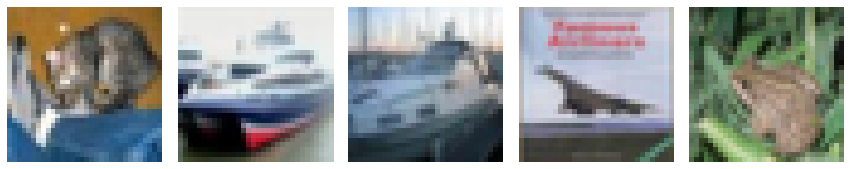

In [6]:
''' Data '''

sample_num=5
for x,y in test_loader:
    input_sp,targets = x[:sample_num,:],y[:sample_num]
    break
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])

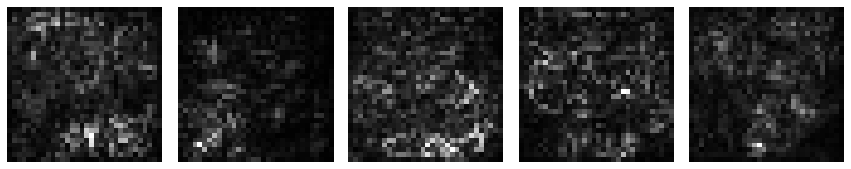

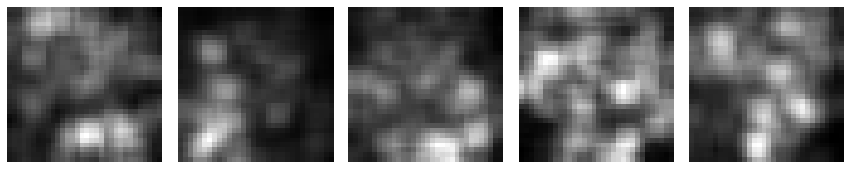

In [40]:
''' Saliency '''
resnet.cpu()
resnet.eval()
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

blurr = torchvision.transforms.GaussianBlur(5, sigma=(3.0, 3.0))
grad = input_var.grad.detach().abs().mean(dim=1).squeeze()

grad_copy = grad.clone()
grad_copy = blurr(grad_copy).squeeze()
grad_min = grad_copy.amin(dim=[1,2],keepdim=True).detach()
grad_copy -= grad_min
grad_max = grad_copy.amax(dim=[1,2],keepdim=True).detach()
grad_copy /=grad_max

# grad_copy = blurr(grad_copy).squeeze()

print_fig(grad/grad.amax(dim=[1,2],keepdim=True).detach())
print_fig(grad_copy)

In [35]:
grad_copy.max()

tensor(1.)

### Ours

1.0


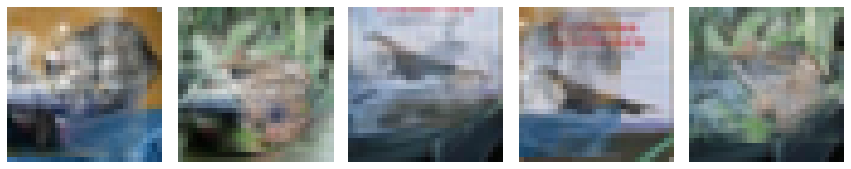

1.6666666666666665


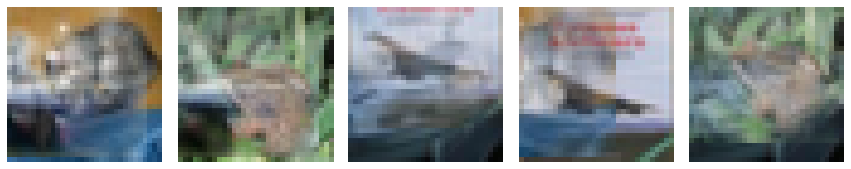

2.333333333333333


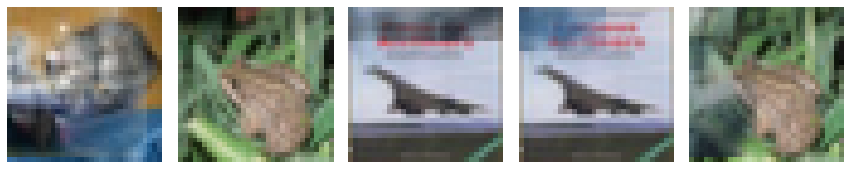

3.0


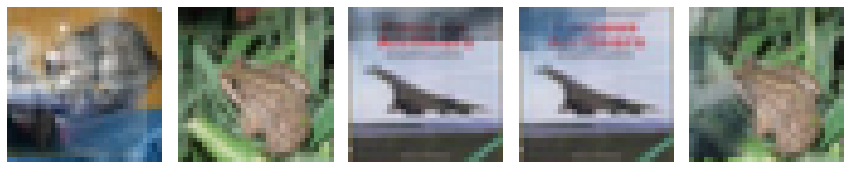

In [31]:
from utils_mixup import gradmix_v2


for _sigma in np.linspace(1,3,4):
    print(_sigma)
    blurr = torchvision.transforms.GaussianBlur(5, sigma=(_sigma, _sigma))

    grad = blurr(input_var.grad.detach().abs().mean(dim=1)).squeeze()

    mixed_x, mixed_y, mixed_lam = gradmix_v2(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), stride = 1, debug=True)

    print_fig(mixed_x.cpu() * std_torch + mean_torch)